In [2]:
import tensorflow as tf
import numpy as np
import os,pathlib

In [3]:
#方法定义

def preprocess_data(dataset):
    all_images = []
    all_labels = []
    for image,label in dataset:
        preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image)
        all_images.append(preprocessed_image)
        all_labels.append(label)
    return np.concatenate(all_images),np.concatenate(all_labels)

def get_r_list():
    index_conv_list = []
    name_conv_list = []
    for i,layer in enumerate(base_model.layers):
        if layer.name[-5:-1] == 'conv':
            index_conv_list.append(i)
            name_conv_list.append(layer.name)
    index_r_list = []
    name_r_list = []
    for j in range(len(name_conv_list)-1):
        if name_conv_list[j][0:6] != name_conv_list[j+1][0:6]:
            index_r_list.append(index_conv_list[j])
            name_r_list.append(name_conv_list[j])
    r_list = [0]
    for i in index_r_list:
        r = i/len(base_model.layers)
        r_list.append(r)
    return r_list

def build_model():
    x = conv_base.output
    predictions = classifier(x)
    model = tf.keras.Model(inputs=conv_base.input,outputs=predictions)
    return model

def r_compiled_model():
    model = build_model()
    for layer in model.layers[:int(r*len(conv_base.layers))+1]:
        layer.trainable = False
    for layer in model.layers[int(r*len(conv_base.layers))+1:]:
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
#加载数据、预处理数据

base_dir = pathlib.Path('elephants')
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'train',
                                                            image_size=(224,224),
                                                            batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'val',
                                                                 image_size=(224,224),
                                                                 batch_size=32)
train_images,train_labels = preprocess_data(train_dataset)
val_images,val_labels = preprocess_data(validation_dataset)

Found 240 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [5]:
#分类器初训练

base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)

inputs = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
classifier_model = tf.keras.Model(inputs=inputs,outputs=outputs)

x = base_model.output
predictions = classifier_model(x)
model = tf.keras.Model(inputs=base_model.input,outputs=predictions)

for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath='vgg_r_1.00.keras',
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
history = model.fit(train_images,train_labels,
                    epochs=15,
                    validation_data=(val_images,val_labels),
                    callbacks=callback_list)
r_1_acc = max(history.history['val_accuracy'])
print(r_1_acc)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 3.4956 - accuracy: 0.5417WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000017731E8BD90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [6]:
#搜索最佳迁移率R(验证理论)

classifier_p = model.get_layer(model.layers[-1].name)
r_list = get_r_list()
best_acc = r_1_acc
r_acc = []

for i in range(len(r_list)):
    r = r_list[i]
    conv_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
    classifier = classifier_p
    model = r_compiled_model()
    filepath = 'vgg_r_{:.2f}.keras'.format(r)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
    history = model.fit(train_images,train_labels,
                        epochs=15,
                        validation_data=(val_images,val_labels),
                        callbacks=callbacks)
    r_acc.append(max(history.history['val_accuracy']))
    
    if i == 0 and r_acc[0] < r_1_acc:
        r_list = r_list[:1]+r_list[:0:-1]
        continue
    if r_acc[i] > best_acc:
        best_acc = r_acc[i]

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.8625 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000177331B8E18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

8/8 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8583WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001773F388620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 78s 10s/step - loss: 0.3107 - accuracy: 0.8583 - val_loss: 0.6180 - val_accuracy: 0.7700
Epoch 2/15
8/8 [=

In [44]:
#观察结果

print(r_list)
print(r_acc)

[0, 0.10526315789473684, 0.2631578947368421, 0.47368421052631576, 0.6842105263157895]
[0.7799999713897705, 0.7699999809265137, 0.7900000214576721, 0.7699999809265137, 0.7900000214576721]


In [45]:
##整理结果

r_list.append(1)
r_acc.append(r_1_acc)
print(r_list)
print(r_acc)

[0, 0.10526315789473684, 0.2631578947368421, 0.47368421052631576, 0.6842105263157895, 1]
[0.7799999713897705, 0.7699999809265137, 0.7900000214576721, 0.7699999809265137, 0.7900000214576721, 0.7200000286102295]


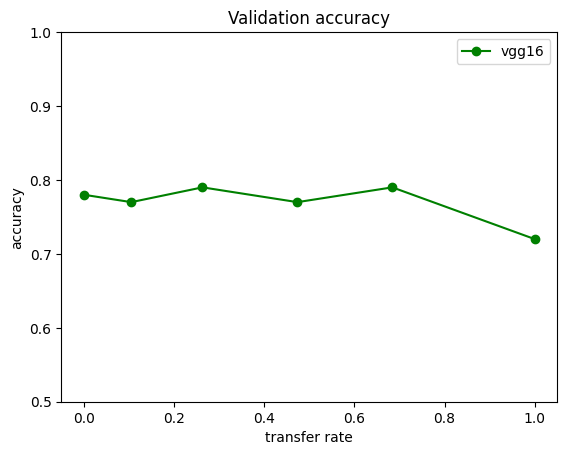

In [60]:
#展示结果

import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='g',label='vgg16')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Validation accuracy')
plt.legend()
plt.show()
